# Joint density of states by Wang-Landau multicanonical sampling

***

In this notebook I provide an implementation of a Wang-Landau algorithm for computing a bivariate joint density of states (DOS) in an integer valued configuration space.

I will make use of the Reciprocity Survey (RS) [dataset](http://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0151588.s002) from:

> Almaatouq A, Radaelli L, Pentland A and Shmueli E (2016) *Are You Your Friends’ Friend? Poor Perception of Friendship Ties Limits the Ability to Promote Behavioral Change.* PLOS ONE 11(3): e0151588. doi:10.1371/journal.pone.0151588


I will model the dataset with the grand-canonical ensemble from:
> [Manuel Jiménez-Martı́n, Javier Rodrı́guez-Laguna and Elka Korutcheva (2017)  *Null models for social hierarchical structure*.](https://arxiv.org/abs/1701.07428)

I will sample sample the configuration space with a Wang-Landau algorithm in order to compute the joint density of states in the macrostate space.
> Fugao Wang and D. P. Landau (2001) *Efficient, Multiple-Range Random Walk Algorithm to Calculate the Density of States.* Phys. Rev. Lett. 86, 2050.

In [82]:
# NECESSARY IMPORTS
import numpy as np
import pandas as pd
import scipy
import random

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

## 1- Dataset description and import

We have fitted the grand-canonical ensemble to the Reciprocity Survey (RS) dataset. In this experiment, a total of $N = 84$ under-graduate students were asked to score their relationship with each of the other participants in a scale from 0 to 5, where 0 meant no-relationship, and 1 to 5 represented increasing degree of friendship. 

We have considered the zero weight as a no-link of cost $0$. The remaining layers costs are $[s_5,s_4,s_3,s_2,s_1]=\{1,2,3,4,5\}$. Then, each participants ego-network is described by a vector whose elements are the weight of their reported relationship with the other participants (the network is directed). 

Let us import the dataset, which I have downloaded to my folder ´~/Downloads´. Then, let us extract the corresponding layer configurations and macrostates. 

In [25]:
df = pd.read_csv(open('/home/mjimenez/Downloads/journal.pone.0151588.s002.CSV','r'))
df.drop(['expected_score'], axis=1, inplace=True)  # we will only use the reported score
df.head()

,nominator,nominated,score
0,68,45,2
1,80,20,0
2,54,49,0
3,0,79,4
4,24,73,1


We can distinguish three deacreasingly detailed representations for the ego-networks:

- The ego-networks are the **microstates** of the system. Six possible weights and $83$ participants make the number of microstates equal to $6^{83}$. 

$$\mathbf{s}_k = [\omega_1,\dots,\omega_{k-1},\omega_{k+1},\dots,\omega_N]\qquad \omega_j\in=[s_5,s_4,s_3,s_2,s_1]$$

- The grand-canonical ensemble assigns the same probability to configurations with equal **layer degrees**,
 $k_r$, that is the number of links of weight $s_r$. Thus, a coarse grained configuration for egonetworks is

$$\{k_r\}=[k_1, k_2, k_3, k_4, k_5]$$

(where k_1 is the number of links of weight $s_1=5$, $k_2$ is the number of links of weight $s_2=4$, etc. Notice that the number of no-links, $k_0$, is not included on the configuration as it can be recovered from $k_0=N-\sum_r k_r$)

- An analogous representation of the layer structure are the accumulated variables, also called **group sizes**:

$$\{n_r\}=[n_1, n_2, n_3, n_4, n_5] \qquad\qquad n_r = \sum_{l=0}^r k_l$$

- Finaly, the **macrostates** of the system are specified by the participants total degree, $k$, and weight $s$.

$$k=\sum_r k_r \qquad \qquad s=\sum_s k_r s_r$$


### Ego-networks (**microstates**):

In [58]:
participants = set(df.nominator)
N = len(participants)
egonets = {}

for participant in participants:
    neighbors = df[df.nominator == participant].nominated.values #loc[:,'nominated']#.loc(:)
    weights = df[df.nominator == participant].score.values
    egonets[participant] = weights[np.argsort(neighbors)]

print('Example of ego-network microstate:', egonets[0])

Example of ego-network microstate: [0 0 4 1 1 2 4 3 3 5 2 2 1 2 3 0 2 1 1 0 3 0 1 5 0 0 1 4 5 2 1 1 0 1 2 1 4
 0 4 1 2 3 2 3 3 1 0 0 1 1 3 0 1 1 1 0 1 4 1 2 0 2 1 0 4 4 0 4 1 3 5 0 1 3
 0 2 2 2 4 0 3 3 0]


### Layer configurations: layer degrees $k_r$ and layer group sizes $n_r$

*(there are 4 links of weight 5, 10 links of weight 4, 12 links of weight 3, etc)*

In [66]:
k_layers = np.zeros((5, N))
n_layers = np.zeros((5, N))
weight_vec = [5,4,3,2,1]

for j in participants:
    for i,w in enumerate(weight_vec):
        k_layers[i,j] = np.sum(egonets[j] == w)
        n_layers[i,j] = np.sum(k_layers[:(i+1),j])

print('Example of layer configuration:\t k_r:', k_layers[:,0], '\tn_r:', n_layers[:,0])

Example of layer configuration:	 k_r: [  4.  10.  12.  14.  23.] 	n_r: [  4.  14.  26.  40.  63.]


### Macrostates: $(k,s)$

In [76]:
k_vec = [np.sum(k_layers[:,i]) for i in range(N)]
s_vec = [np.sum(k_layers[:,i] * np.array(weight_vec)) for i in range(N)]

print('Example of k-s macrostate\tk=', k_vec[0], '\ts=', s_vec[0])

Example of k-s macrostate	k= 63.0 	s= 147.0


## 2- Model description and class definition for Wang-Landau sampling

The grand-canonical ensemble for ego-networks is obtained as the Maximum Entropy probability distribution such that its average values $<k>$ and $<s>$ are those observed in the data. Maximizing the entropy, $S=-\sum_{k_r} D(\{k_r\})P(\{k_r\}) \ln [D(\{k_r\}) P(\{k_r\})]$, subject to the conditions

$$\langle k\rangle = \sum_{j=1}^N \left(\textstyle\sum_r k_r^{(j)} \right) P(\{k_r\})  \qquad\qquad
  \langle s\rangle = \sum_{j=1}^N \left(\textstyle\sum_r s_r k_r^{(j)} \right) P(\{k_r\})$$
  
plus normalization, $\sum_{k_r}P(\{k_r\})=1$, gives a Gibbs distribution

$$  P(\{k_r\}) =  \frac{1}{Z} D(\{k_r\}) e^{\lambda k + \mu s} , $$

where $D(\{k_r\}=k!/\prod_r k_r!$ is the layer configuration degeneracy, that is, the number of different microstates with the same layer degrees $\{k_r\}$. 

***

We want compute the **density of states** (DOS) in the macrostate space $k$-$s$ for the grand-canonical ensemble. The Wang-Landau algorithm allows to compute the actual DOS on specific domain, including regions that would be otherwise imposible to sample with a Monte Carlo method. The density of states in the **macrostate** space is

$$P(k,s)=\sum_{\{k_r\}} P(\{k_r\}) \textstyle \delta(k-\sum_r k_r)\delta(s-\sum_r k_r s_r) =\displaystyle \frac{1}{Z} \rho(k,s)e^{\lambda k + \mu s} $$

Here, $\rho(k,s)$ is the *zero-temperature* density of states (0-DOS), that is, the total degeneracy of a given macrostate $k$-$s$. The Wang-Landau is a Monte Carlo algorithm that allows us to compute $\rho(k,s)$ adaptively by sampling the configuration space with probability $1/\rho(k,s)$. Such a sampling procedure generates a flat histogram in the macrostate space. 

In practice, we start with a uniform $\rho_0(k,s)$ and an empty histogram $h(k,s)$. We perform a random walk on the configuration (microstate) space and every iteration we update the 0-DOS and the histogram as follows.

$$\rho_i(k,s) = \rho_i(k,s) \cdot f_i$$
$$h_i(k,s) = h_i(k,s) + 1$$

Where $f$ is a parameter larger than $1$. During the first walk, we perform a long run and define the **valid** domain as those values of $k$-$s$ that have been visited at least once. We then continue the walk, and check whether the histogram is sufficiently **flat** *(for instance, if at least 99% of the **valid** histogram entries are higher than $0.8\langle h \rangle$, where $\langle h \rangle$ is the histogram average)*.

If the histogram is sufficiently flat, we reset it, update the parameter $f$ and start a new walk. The algorithm now should perform finer updates to the 0-DOS. Thus, the parameter $f$ should decrease following a monotonically decreasing mapping such as 

$$\rho_{i+1} = \rho_{i}$$
$$h_{i+1} = \text{const}$$ 
$$f_{i+1} = \sqrt{f_i}$$

After $n$ rounds, the update parameter should be approximately $1$. For instance, starting at   $f_0=e^1$, after $10$ rounds the update parameter is $f_0^{1/2^{10}}\approx 1.001$.

Finally, we obtain the model's DOS, $P(k,s)$ by reweighting $\rho(k,s)$ with the Gibbs factor $e^{\lambda k + \mu s}/Z$.

***

Let us englobe the necessary functions for the algorithm on an object: `egonet`

In [94]:
class egonet(object):
    
    def __init__(self, N, f=np.exp(1), costs=[0,1,2,3,4,5]):
        # INITIALIZATION
        # number of actors, layer costs (weights) and number of layers
        self.N = N
        self.costs = np.array(costs)
        self.L = len(self.costs)   # number of layers
        # microstate
        self.state = np.array([random.choice(self.costs) for _ in range(self.N-1)])  # N-1 links
        # macrostate
        self.k = np.sum(self.state > 0)
        self.s = np.sum(self.state)
        # histogram and zero temperature DOS
        # we store the log-DOS instead of the DOS (otherwise we would have overflow problems)
        self.histogram = np.ones((self.N, self.N * np.max(costs))) 
        self.logdensity = np.zeros((self.N, self.N * np.max(costs)))  
        # update parameter and acceptance ratio
        self.f = f
        self.acc_ratio = 0.

    def wang_landau_move(self):
        # elementary MC move, propose new microstate and accept it with p ~ 1/rho
        j = random.randint(0, self.N-2)
        wj = self.state[j]
        new_wj = self.costs[random.randint(0, self.L-1)]
        new_k = self.k + (wj == 0) - (new_wj == 0)
        new_s = self.s - wj + new_wj 
        if random.random() < np.min([1, np.exp(self.logdensity[self.k, self.s] - self.logdensity[new_k, new_s])]):
            self.state[j] = new_wj
            self.k = new_k
            self.s = new_s
            self.acc_ratio += 1
        return

    def wang_landau_run(self, n_moves):
        # perform n_moves wang landau elementary moves
        self.acc_ratio = 0
        for i in range(n_moves):
            self.wang_landau_move()
            self.histogram[self.k, self.s] += 1
            self.logdensity[self.k, self.s] += np.log(self.f) # sum of logarithms instead of multiplication
        self.acc_ratio /= n_moves
        return
    
    def wang_landau(self, n_moves, n_rounds, threshold):
        # MAIN LOOP OF THE ALGORITHM
        # initial round
        self.wang_landau_run(1000000)
        # only valid elements will be used to check histogram flatness
        # we consider valid those larger than 0.1 of the mean of the nonzero elements
        self.valid = (self.histogram > 0.1 * self.histogram[self.histogram > 1].mean())
        print('Initial run\tf =', self.f, ' acc. ratio', round(self.acc_ratio,3),
                         '\tflatness:', round(self.hist_flatness(),3), '\n')
        # start subsequent rounds
        for run in range(n_rounds):
            # check flatness, restart histogram, update parameter
            while True:
                self.wang_landau_run(n_moves)
                print(run, 'round\tf =', self.f,  '\tacc. ratio', round(self.acc_ratio,3),
                           '\tflatness:', round(self.hist_flatness(),3))
                if self.hist_flatness() > threshold:
                    self.histogram = np.zeros((self.N, self.N * self.costs[-1]))
                    self.f = np.sqrt(self.f)
                    print('Flat! Reseting histogram...\n')
                    break
        return
    
    def hist_flatness(self):
        # computes proportion of valid histogram points that are sufficiently flat
        reshaped_hist = self.histogram[self.valid]
        mu = np.mean(reshaped_hist)
        return np.sum(reshaped_hist > 0.8*mu) / len(reshaped_hist)

### Now, run the algorithm

In [96]:
E = egonet(84)
# 1000000 attempted moves per round, 10 rounds, 
# and at least 0.9 of the valid histogram entries must be highe than 0.8*mean(histogram)
E.wang_landau(500000, 10, 0.95)  

Initial run	f = 2.71828182846  acc. ratio 0.624 	flatness: 0.673 

0 round	f = 2.71828182846 	acc. ratio 0.552 	flatness: 0.722
0 round	f = 2.71828182846 	acc. ratio 0.541 	flatness: 0.761
0 round	f = 2.71828182846 	acc. ratio 0.513 	flatness: 0.812
0 round	f = 2.71828182846 	acc. ratio 0.517 	flatness: 0.84
0 round	f = 2.71828182846 	acc. ratio 0.498 	flatness: 0.889
0 round	f = 2.71828182846 	acc. ratio 0.514 	flatness: 0.905
0 round	f = 2.71828182846 	acc. ratio 0.482 	flatness: 0.94
0 round	f = 2.71828182846 	acc. ratio 0.494 	flatness: 0.962
Flat! Reseting histogram...

1 round	f = 1.6487212707 	acc. ratio 0.28 	flatness: 0.062
1 round	f = 1.6487212707 	acc. ratio 0.359 	flatness: 0.416
1 round	f = 1.6487212707 	acc. ratio 0.461 	flatness: 0.547
1 round	f = 1.6487212707 	acc. ratio 0.477 	flatness: 0.606
1 round	f = 1.6487212707 	acc. ratio 0.512 	flatness: 0.694
1 round	f = 1.6487212707 	acc. ratio 0.518 	flatness: 0.803
1 round	f = 1.6487212707 	acc. ratio 0.49 	flatness: 0.912


## 3- Visualization 

Before plotting the DOS, we need to fit the grand-canonical ensemble to the RS dataset. Let us rename the fitting parameters $x=e^{\lambda}$ and $y=e^{\mu}$. Then, we can express the density of states as:

$$P(k,s) \propto \rho(k,s) x^k y^s$$

The fitted values of $x$ and $y$ are obtained with the saddle point equations.

$$\langle k \rangle = \frac{N\sum_r x y^{s_r}}{1 + \sum_r x y^{s_r}} 
\qquad\qquad  \langle s \rangle  = \frac{N\sum_r s_r x y^{s_r}}{1 + \sum_r x y^{s_r}} $$ 

RS average values of $\langle k \rangle= 73.63$ and $\langle s \rangle = 145.45$ give $x= 6.59154$ and $y=0.557557$.

*(read the paper [here]() for the specifics)*

Now let's plot it!

/home/mjimenez/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log


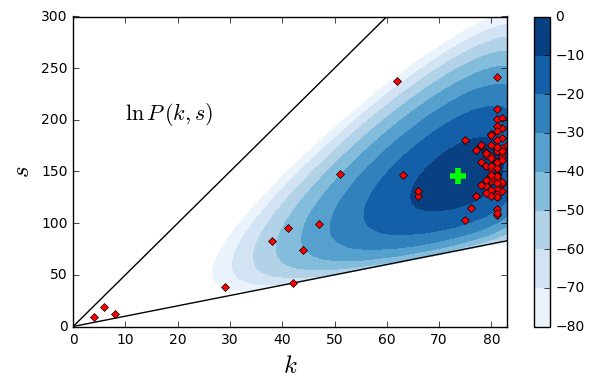

In [151]:
k_av, s_av = np.mean(k_vec), np.mean(s_vec)
x, y = 6.59154, 0.557557
kmax, smax = np.shape(E.logdensity)
# reweight the zero temperature density by the Gibbs factor
Gibbs = np.array([[(np.log(x)*k + np.log(y)*s)*(s >= k) for s in range(smax)] for k in range(kmax)])
# rescale the density so we can take exponential
A=700
rescaled_prob = np.exp(E.logdensity - A + Gibbs) * E.valid
# normalize the resulting probability
rescaled_prob /= np.sum(rescaledprob[E.valid])

sv = np.linspace(0, 5*N, 5*N)
kv = np.linspace(0, N, N)
KV, SV = np.meshgrid(kv,sv)

fig, ax = plt.subplots(figsize=(7,4))
# allowed region is s>=k and s<= k*s_max
kx = np.arange(0,84)
ax.plot(kx, kx,'k')
ax.plot(kx, 5*kx, 'k')
# plot the RS data and its averages
ax.plot(k_vec, s_vec, 'D', c='red', ms=4, label='RS data')
ax.plot(k_av, s_av, '+', c='lime', mew=4, ms=12, label='Averages)
# plot the log-density (warning because of log(0)=-inf but these values won't appear on the plot)
contour = ax.contourf(KV, SV, np.log(rescaled_prob.T),
                      levels=[-80,-70,-60,-50,-40,-30,-20,-10,0], cmap='Blues')
        
plt.colorbar(contour)
ax.set(xlabel=r'$k$', ylabel=r'$s$', xlim=[0,83], ylim=[0, 300])
ax.yaxis.label.set_size(18)
ax.xaxis.label.set_size(18)
ax.text(10, 200, r'$\ln\,P\,(k,s)$', fontsize=16)

The green cross marks the $\langle k \rangle$ and $\langle s \rangle$ RS empirical averages and the red diamods represent the $84$ individual ego-networks. We have fitted the grand-canonical ensemble such that the expected $k$ and $s$ coincide with the empirical averages. The blue-shaded regions are the contour plot of the logarithmic density of states. Finally, the black lines delimit domain for the allowed configurations: $s\geq k$ and $s\leq 5k$.